In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [39]:
# 1. Đọc dữ liệu
df = pd.read_csv("data 9.13.csv")
df.columns = [c.strip().replace(" ", "_").replace("/", "_") for c in df.columns]


In [40]:
# 2. Target numeric (Hiệu suất chuyền %)
df["Hiệu_suất_chuyền"] = pd.to_numeric(
    df["Hiệu_suất_chuyền"].replace(" - ", np.nan),
    errors="coerce"
)
df = df.dropna(subset=["Hiệu_suất_chuyền"]).reset_index(drop=True)

In [41]:
# 3. Encode categorical
categorical_cols = ["Độ_trơn_(mô_tả)", "Độ_co_giãn_(mô_tả)", "Bố_trí_&_cân_bằng_(mô_tả)"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [42]:
# 4. Xử lý numeric (%)
df["Tỷ_lệ_máy_phù_hợp_(%)"] = df["Tỷ_lệ_máy_phù_hợp_(%)"].astype(float)

In [43]:
# 5. Input / Output
X = df[[
    "Số_lượng",
    "Số_màu_đơn_hàng",
    "GSM_(g_m²)",
    "Độ_trơn_(mô_tả)",
    "Độ_co_giãn_(mô_tả)",
    "SMV_(phút_pc)",
    "Lao_động_trực_tiếp",
    "Bậc_thợ_TB_(2–5)",
    "Bố_trí_&_cân_bằng_(mô_tả)",
    "Tỷ_lệ_máy_phù_hợp_(%)"
]]
y = df["Hiệu_suất_chuyền"]

In [45]:
# 6. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale numeric
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
# 7. Define models
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=-1, random_state=42
    ),
    "CatBoost": CatBoostRegressor(
        iterations=300, learning_rate=0.05, depth=6, random_seed=42, verbose=0
    ),
    "Linear Regression": LinearRegression(),
    "MLP Regressor": MLPRegressor(
        hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42
    )
}

In [47]:
# 8. Train & Evaluate
results = {}
predictions = {}

for name, model in models.items():
    # Với CatBoost và LightGBM thì không cần scale, nhưng để đồng nhất thì dùng scaled luôn
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    predictions[name] = (y_train_pred, y_test_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results[name] = {
        "Train_R²": r2_score(y_train, y_train_pred),
        "Test_R²": r2_score(y_test, y_test_pred),
        "Train_MAE(%)": mean_absolute_error(y_train, y_train_pred),
        "Test_MAE(%)": mean_absolute_error(y_test, y_test_pred),
        "Train_RMSE(%)": rmse_train,
        "Test_RMSE(%)": rmse_test
    }

results_df = pd.DataFrame(results).T
print("\n=== Model Evaluation (Hiệu suất chuyền %) ===")
print(results_df.round(3))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 105, number of used features: 10
[LightGBM] [Info] Start training from score 89.082381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\nhat2\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\nhat2\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Model Evaluation (Hiệu suất chuyền %) ===
                   Train_R²  Test_R²  Train_MAE(%)  Test_MAE(%)  \
Random Forest         0.901    0.767         2.341        3.688   
XGBoost               0.999    0.743         0.212        3.949   
Gradient Boosting     1.000    0.720         0.020        4.156   
LightGBM              0.909    0.702         2.269        4.200   
CatBoost              0.995    0.764         0.594        3.749   
Linear Regression     0.603    0.611         4.674        4.913   
MLP Regressor         0.722   -0.854         3.819       10.742   

                   Train_RMSE(%)  Test_RMSE(%)  
Random Forest              2.951         4.780  
XGBoost                    0.278         5.023  
Gradient Boosting          0.026         5.246  
LightGBM                   2.826         5.413  
CatBoost                   0.693         4.810  
Linear Regression          5.903         6.181  
MLP Regressor              4.942        13.495  


C:\Users\nhat2\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\nhat2\AppData\Local\Temp\ipykernel_16464\3737204400.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y="Test_R²", data=results_df, ax=axes[0], palette="viridis")
C:\Users\nhat2\AppData\Local\Temp\ipykernel_16464\3737204400.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y="Test_MAE(%)", data=results_df, ax=axes[1], palette="magma")


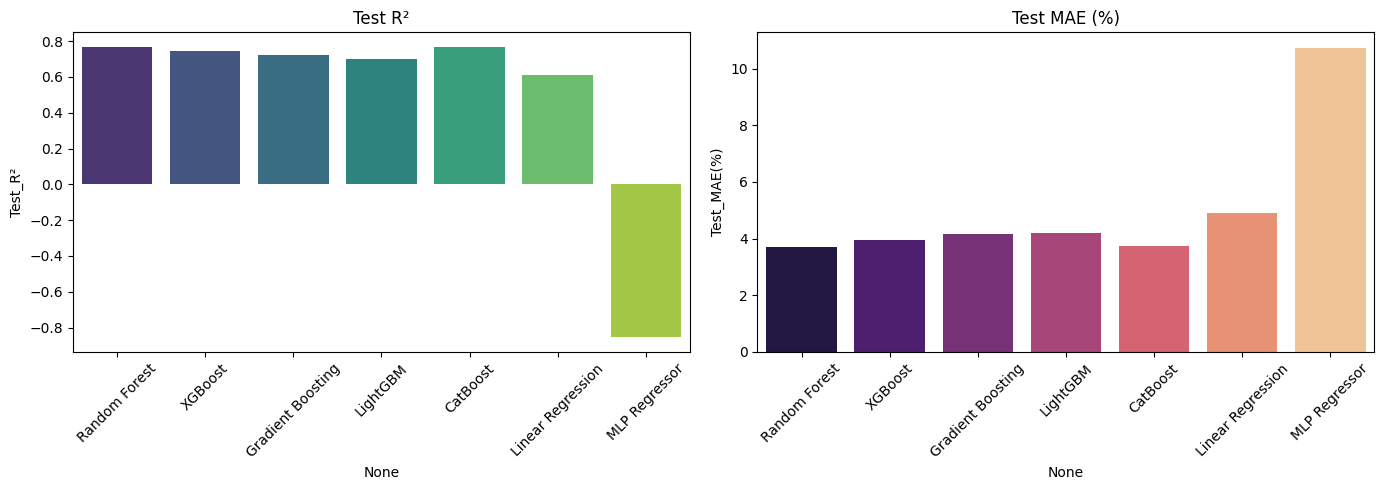

In [48]:
# 9. So sánh trực quan các mô hình (Test R² và MAE)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x=results_df.index, y="Test_R²", data=results_df, ax=axes[0], palette="viridis")
axes[0].set_title("Test R²")
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x=results_df.index, y="Test_MAE(%)", data=results_df, ax=axes[1], palette="magma")
axes[1].set_title("Test MAE (%)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

C:\Users\nhat2\AppData\Local\Temp\ipykernel_16464\3513261860.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=imp_df, palette="viridis")


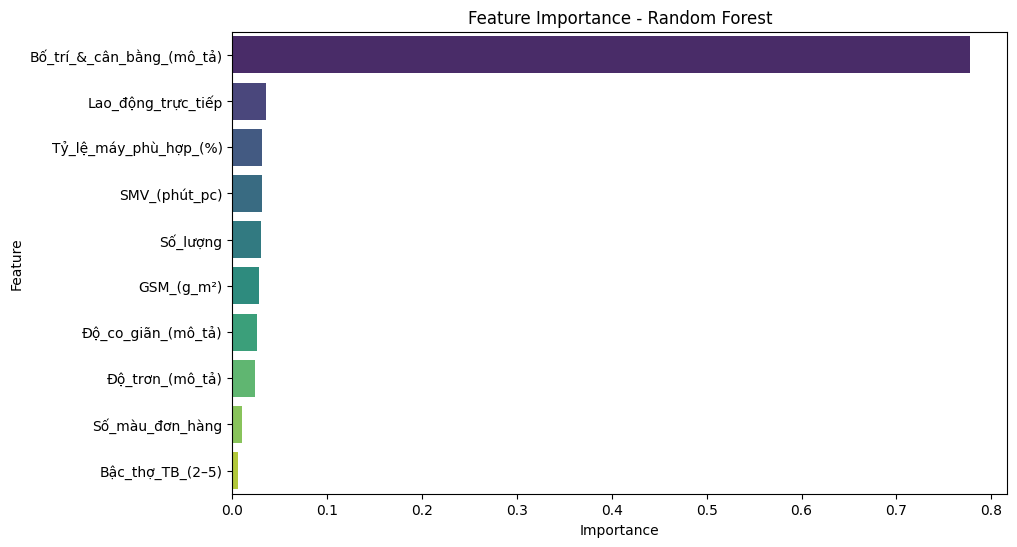

In [49]:
# 10. Feature importance - Random Forest
rf = models["Random Forest"]
importances = rf.feature_importances_
feat_names = X.columns

imp_df = pd.DataFrame({"Feature": feat_names, "Importance": importances})
imp_df = imp_df.sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=imp_df, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.show()


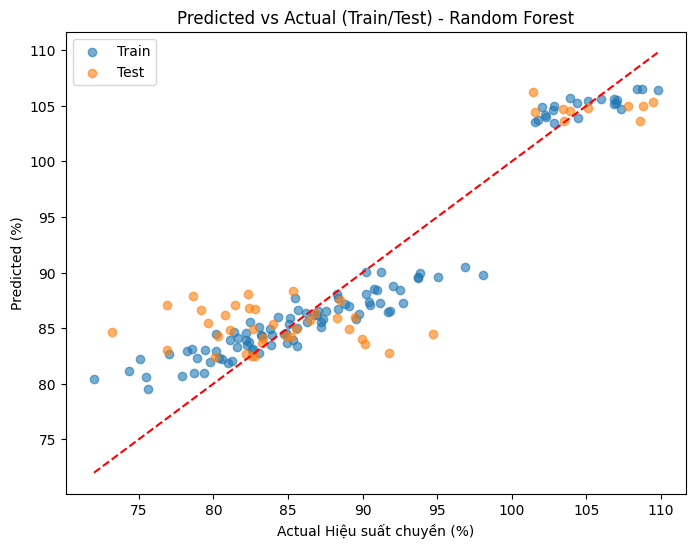

In [50]:
# 11. Predicted vs Actual (Test set - ví dụ Random Forest)
y_train_pred, y_test_pred = predictions["Random Forest"]

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, label="Train", alpha=0.6)
plt.scatter(y_test, y_test_pred, label="Test", alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Actual Hiệu suất chuyền (%)")
plt.ylabel("Predicted (%)")
plt.title("Predicted vs Actual (Train/Test) - Random Forest")
plt.legend()
plt.show()
